<a href="https://colab.research.google.com/github/LRManamperi/Machine-Learning/blob/main/SQLAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain_openai langchain_community

In [2]:
import getpass
import os

def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")

_set_env("GROQ_API_KEY")


GROQ_API_KEY:··········


In [3]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    # Open a local file in binary write mode
    with open("Chinook.db", "wb") as file:
        # Write the content of the response (the file) to the local file
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded and saved as Chinook.db


In [4]:
%%capture --no-stderr --no-display
!pip install langgraph langchain_community langchain_openai

In [5]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

In [6]:
from typing import Any

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

In [9]:
import os
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import ChatOpenAI
from langchain_community.utilities import SQLDatabase

# Make sure the GROQ_API_KEY is set in the environment
# (You can also set it in code with: os.environ["GROQ_API_KEY"] = "your-key")

# Initialize the database (update this to your actual DB URI)
db = SQLDatabase.from_uri("sqlite:///Chinook.db")

# Initialize the Groq LLM
llm = ChatOpenAI(
    model_name="mixtral-8x7b-32768",  # or "llama3-8b-8192", etc.
    base_url="https://api.groq.com/openai/v1",
    api_key=os.environ["GROQ_API_KEY"]
)

# Set up the toolkit
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

# Access specific tools
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

# Use the tools
print(list_tables_tool.invoke(""))
print(get_schema_tool.invoke("Artist"))



Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


In [10]:
from langchain_core.tools import tool


@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result


print(db_query_tool.invoke("SELECT * FROM Artist LIMIT 10;"))

[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]


In [12]:
import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable
from langchain_openai import ChatOpenAI
from langchain_core.tools import Tool

# Example dummy tool to simulate query execution
def run_query(input: str) -> str:
    return f"Executed: {input}"

db_query_tool = Tool(
    name="db_query_tool",
    description="Executes SQL query on the database.",
    func=run_query
)

# Use supported Groq model
llm = ChatOpenAI(
    model_name="llama3-8b-8192",
    base_url="https://api.groq.com/openai/v1",
    api_key=os.environ["GROQ_API_KEY"],
    temperature=0,
)

# System prompt
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

# Prompt setup
query_check_prompt = ChatPromptTemplate.from_messages([
    ("system", query_check_system),
    ("human", "{messages}")
])

# Bind tool
query_check: Runnable = query_check_prompt | llm.bind_tools(
    [db_query_tool], tool_choice="required"
)

# Call the chain
response = query_check.invoke({
    "messages": "SELECT * FROM Artist LIMIT 10;"
})

print(response)


content='' additional_kwargs={'tool_calls': [{'id': 'call_n0wv', 'function': {'arguments': '{"__arg1":"SELECT * FROM Artist LIMIT 10;"}', 'name': 'db_query_tool'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 953, 'total_tokens': 1035, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'queue_time': 0.017010110999999994, 'prompt_time': 0.17846952, 'completion_time': 0.068333333, 'total_time': 0.246802853}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_a97cfe35ae', 'id': 'chatcmpl-f7d00a18-0697-4afb-8011-d712613a4adf', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-21477d69-00a9-474b-a3d3-8a592063124d-0' tool_calls=[{'name': 'db_query_tool', 'args': {'__arg1': 'SELECT * FROM Artist LIMIT 10;'}, 'id': 'call_n0wv', 'type': 'tool_call'}] usage_metadata={'input_tokens': 953, 'output_tokens': 82, 'total_tokens': 1035, 'input_token_details': {}, 'output_token_details': {}}


In [14]:
from typing import Annotated, Literal
from langchain_core.messages import AIMessage, ToolMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.prompts import ChatPromptTemplate
import os

# Define the state for the agent
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Setup Groq-compatible LLM
llm_groq = ChatOpenAI(
    model_name="llama3-8b-8192",
    base_url="https://api.groq.com/openai/v1",
    api_key=os.environ["GROQ_API_KEY"],
    temperature=0,
)

# Define the query checking prompt and tool
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
)

query_check = query_check_prompt | llm_groq.bind_tools(
    [db_query_tool], tool_choice="required"
)

# Define workflow
workflow = StateGraph(State)

# Add a node for the first tool call
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "tool_abcd123",
                    }
                ],
            )
        ]
    }

# Add a node to model-check query
def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}

# Add workflow nodes
workflow.add_node("first_tool_call", first_tool_call)
workflow.add_node("list_tables_tool", create_tool_node_with_fallback([list_tables_tool]))
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# Bind get schema tool with Groq model
model_get_schema = llm_groq.bind_tools([get_schema_tool])
workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)

# Define SubmitFinalAnswer tool
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""
    final_answer: str = Field(..., description="The final answer to the user")

# Prompt for query generation
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set.
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""

query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", query_gen_system), ("placeholder", "{messages}")]
)

query_gen = query_gen_prompt | llm_groq.bind_tools([SubmitFinalAnswer])

# Query generation node
def query_gen_node(state: State):
    message = query_gen.invoke(state)

    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    return {"messages": [message] + tool_messages}

workflow.add_node("query_gen", query_gen_node)

# Add node for query checking
workflow.add_node("correct_query", model_check_query)

# Add node for executing query
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))

# Control logic for conditional edges
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]
    last_message = messages[-1]
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"

# Connect the graph nodes
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges("query_gen", should_continue)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# Compile the workflow
app = workflow.compile()


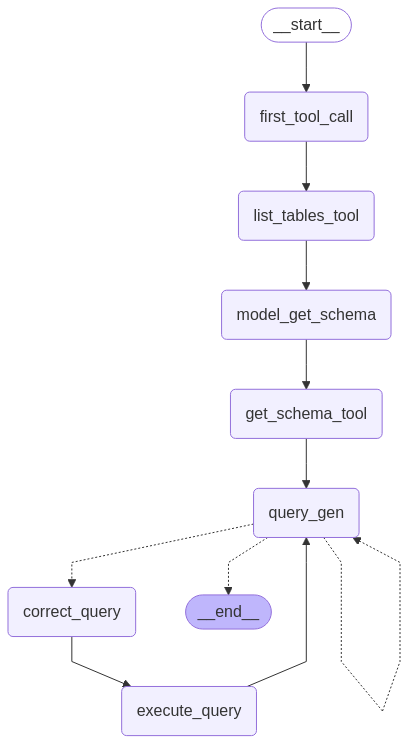

In [15]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(Image(app.get_graph().draw_mermaid_png()))

In [16]:
messages = app.invoke(
    {"messages": [("user", "Which sales agent made the most in sales in 2009?")]}
)
json_str = messages["messages"][-1].tool_calls[0]["args"]["final_answer"]
json_str

'Luís Gonçalves'

In [17]:
for event in app.stream(
    {"messages": [("user", "Which sales agent made the most in sales in 2009?")]}
):
    print(event)

{'first_tool_call': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={}, id='16c80ab3-de28-44c7-878e-5ea2032f39bc', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}])]}}
{'list_tables_tool': {'messages': [ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='9a06eed3-e6de-4596-9e22-803a473aa84a', tool_call_id='tool_abcd123')]}}
{'model_get_schema': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nx2s', 'function': {'arguments': '{"table_names":"Customer"}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 1076, 'total_tokens': 1111, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'queue_time': 0.02403470099999999, 'prompt_time': 0.135571199, 'completion_time': 0.

In [18]:
import json


def predict_sql_agent_answer(example: dict):
    """Use this for answer evaluation"""
    msg = {"messages": ("user", example["input"])}
    messages = app.invoke(msg)
    json_str = messages["messages"][-1].tool_calls[0]["args"]
    response = json_str["final_answer"]
    return {"response": response}

In [19]:
import os
from langchain import hub
from langchain_openai import ChatOpenAI

# Load the prompt from LangChain Hub
grade_prompt_answer_accuracy = hub.pull("langchain-ai/rag-answer-vs-reference")

def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy using Groq
    """

    # Get question, ground truth answer, and model prediction
    input_question = example.inputs["input"]
    reference = example.outputs["output"]
    prediction = run.outputs["response"]

    # Set up Groq-compatible LLM
    llm = ChatOpenAI(
        model="llama3-8b-8192",
        base_url="https://api.groq.com/openai/v1",
        api_key=os.environ["GROQ_API_KEY"],
        temperature=0,
    )

    # Bind the grading prompt with the LLM
    answer_grader = grade_prompt_answer_accuracy | llm

    # Run evaluator
    result = answer_grader.invoke(
        {
            "question": input_question,
            "correct_answer": reference,
            "student_answer": prediction,
        }
    )

    # Extract score (assuming the response format includes a "Score" field)
    score = result.get("Score", 0)

    return {
        "key": "answer_v_reference_score",
        "score": score
    }


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:280: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [24]:
from langsmith.evaluation import evaluate

dataset_name = "SQL Agent Response"
try:
    experiment_results = evaluate(
        predict_sql_agent_answer,
        data=dataset_name,
        evaluators=[answer_evaluator],
        num_repetitions=3,
        experiment_prefix="sql-agent-multi-step-response-v-reference",
        metadata={"version": "Chinook, gpt-4o multi-step-agent"},
    )
except:
    print("Please setup LangSmith")

Please setup LangSmith


In [23]:
import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq  # Make sure this is installed: pip install langchain-groq
from langchain import hub

# ✅ Set your LangSmith API Key
os.environ["LANGCHAIN_API_KEY"] = "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"

# ✅ Set up the prompt from LangChain Hub (now it will work)
grade_prompt_answer_accuracy = hub.pull("langchain-ai/rag-answer-vs-reference")

# ✅ Set up the evaluator using Groq
llm = ChatGroq(model="mixtral-8x7b-32768", temperature=0)

answer_grader = grade_prompt_answer_accuracy | llm


# ✅ Evaluation function
def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy using Groq.
    """

    input_question = example.inputs["input"]
    reference = example.outputs["output"]
    prediction = run.outputs["response"]

    score_dict = answer_grader.invoke({
        "question": input_question,
        "correct_answer": reference,
        "student_answer": prediction,
    })

    score = score_dict["Score"]

    return {"key": "answer_v_reference_score", "score": score}


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:280: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [22]:
 pip install langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 4.8 MB/s eta 0:00:00


In [25]:
from langsmith.evaluation import evaluate

dataset_name = "SQL Agent Response"
try:
    experiment_results = evaluate(
        predict_sql_agent_answer,
        data=dataset_name,
        evaluators=[answer_evaluator],
        num_repetitions=3,
        experiment_prefix="sql-agent-multi-step-response-v-reference",
        metadata={"version": "Chinook, gpt-4o multi-step-agent"},
    )
except:
    print("Please setup LangSmith")

Please setup LangSmith
